In [168]:
import pandas as pd
import numpy as np
from pycox.datasets import support
from sksurv import nonparametric
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.datasets import load_rossi
import matplotlib.pyplot as plt
import collections

In [169]:
df = pd.read_csv("/Users/lerdp/Desktop/ich_topicmodeling/ich_preprocess.csv", sep = ",")

In [170]:
def extractFromDict(dictionary, key_lst):
    # Create a list of values accessed from a dictionary
    temp = []
    for key in key_lst:
        try:
            value = dictionary[key]
        except:
            value = None
        temp.append(value)
    return temp 

def transformEthnic(df, col_name):
    # After transformation, there will be these ethnic: white, asian, black, latino, other, NA. 
    assert col_name in df.columns.tolist()
    temp = []
    for val in df[col_name].tolist():
        ethnic = ""
        if val in ["white", "asian", "black", "latino", "other", "NA"]:
            ethnic = val
        elif val == "w" or val.find("white") != -1:
            ethnic = "white"
        elif val.find("asia") != -1:
            ethnic = "asian"
        elif val.find("black") != -1:
            ethnic = "black"
        elif val.find("decline") != -1 or val.find("unknown") != -1 or val.find("unable") != -1:
            ethnic = "NA"
        elif val.find("latino") != -1:
            ethnic = "latino"
        else:
            ethnic = "other"
        temp.append(ethnic)
    return temp

def NIHSS_score(pre_inicu_df):
    # @param pre_inicu_df: A dataframe containing all covariates used to calculate NIHSS score 
    pass

In [171]:
# Extract first time inicu, first time outicu, and how many days a patient spent on their first admit
# Variable created: inicu_time, outicu_time, days_in_icu, deceased_time

temp = df[df["event"] == "inicu"]
temp = temp.drop_duplicates(subset = ["pt","event"], keep = "first")
inicu_time_dict = dict(zip(temp["pt"], temp["t"]))

temp = df[df["event"] == "outicu"]
temp = temp.drop_duplicates(subset = ["pt","event"], keep = "first")
outicu_time_dict = dict(zip(temp["pt"],temp["t"]))

days_in_icu_dict = {}
second_per_day = 60*60*24
for key in list(inicu_time_dict.keys()):
    days_in_icu_dict[key] = round((outicu_time_dict[key] - inicu_time_dict[key])/second_per_day,3)
    
temp = df[df["event"] == "deceased"].drop_duplicates(subset = ["pt","event"], keep = "first")
deceased_time_dict = dict(zip(temp["pt"],temp["t"]))

In [172]:
# Extract birthday, ethnicity, gender (stored always on top)
# Because birthday is always at the first appearance, dropping duplicates would get birth time. 
age_at_admit_dict = {}
ethnic_dict = {}
gender_dict = {}
second_per_year = (365.25*24)*60*60
for pt in list(inicu_time_dict.keys()):
    # Obtain index
    birth_index = df[df["pt"] == pt].index[0]
    ethnic_index = birth_index+1
    gender_index = birth_index+2
    # Obtain value
    age = (inicu_time_dict[pt] - df.iloc[birth_index]["t"])/second_per_year
    age = round(age, 2)
    ethnic = df.iloc[ethnic_index]["event"].strip("ethnicity:")
    gender = df.iloc[gender_index]["event"].strip("gender:")
    # Store value
    age_at_admit_dict[pt] = age
    ethnic_dict[pt] = ethnic
    gender_dict[pt] = gender

In [173]:
newdf = pd.DataFrame(columns = ["pt"])
newdf["pt"] = list(inicu_time_dict.keys())

# List of variables to add 
var_name = ["inicu_time","outicu_time","deceased_time","days_in_icu"]
var_name += ["age_at_admit","ethnic","gender"]
var_dict = [inicu_time_dict, outicu_time_dict, deceased_time_dict, days_in_icu_dict]
var_dict += [age_at_admit_dict, ethnic_dict, gender_dict]
for i,var in enumerate(var_name):
    newdf[var] = extractFromDict(var_dict[i], newdf["pt"].tolist())
newdf["ethnic"] = transformEthnic(newdf, "ethnic")

In [174]:
# Deceased time
fully_observed = []
for index in newdf["pt"].index.tolist():
    all_info = newdf.iloc[index]
    deceased_time = all_info["deceased_time"]
    inicu_time = all_info["inicu_time"]
    outicu_time = all_info["outicu_time"]
    temp = None
    if deceased_time == None: # Never deceased, so fully observed
        temp = 1
    elif deceased_time < outicu_time and deceased_time > inicu_time:
        temp = 0
    else: 
        temp = 1
    fully_observed.append(temp)
newdf["death_in_icu"] = pd.Series(fully_observed)

# Time structure of the dataset
## Operations completed prior to ICU


## Operations one day after ICU admittance

In [175]:
# Possible variables: 
dem_var = ["chart:religion:", "chart:admit wt:kg","chart:speech:", "chart:gag reflex:", 
           "lab:urine:hematology:glucose", "chart:cough reflex:", "insurance:medicare","chart:behavior:",
          "chart:communication:","chart:mental status:","marital_status:single"]
start = 0
stop = start+50

In [176]:
# Create a dataframe of all test run before ICU
# Goal: Understand what happens before
pre_inicu_df = pd.DataFrame(columns = df.columns.tolist())
day_after_admit = pd.DataFrame(columns = df.columns.tolist())
second_in_day = 24*60*60
for pt in newdf["pt"].tolist():
    ub = inicu_time_dict[pt] + second_in_day
    temp = df[df["pt"] == pt]
    temp = temp[temp["t"].le(ub)]
    frame = [pre_inicu_df, temp]
    pre_inicu_df = pd.concat(frame)

In [10]:
pre_inicu_df[pre_inicu_df["event"] == "inicu"]

,pt,t,event,value
140,9.0,5675767622.0,inicu,5.3231
9864,67.0,5930171238.0,inicu,0.2148
10306,81.0,7006434647.0,inicu,1.5137
16667,103.0,5511899533.0,inicu,0.7639
19433,203.0,6004913004.0,inicu,9.5551
...,...,...,...,...
8804429,99282.0,4294029984.0,inicu,3.5522
8808760,99286.0,6002905762.0,inicu,3.6891
8814105,99366.0,7170350277.0,inicu,7.7437
8825523,99589.0,5497469829.0,inicu,0.7933


In [177]:
pt_id = newdf["pt"].tolist()[30]
temp = df[df["pt"] == pt_id]
# 24 hours after admittance to ICU for a specific patient
one_day = temp[temp["t"].between(inicu_time_dict[pt_id], inicu_time_dict[pt_id] + second_per_day)]
new_index = (np.array(one_day["t"])-one_day["t"].tolist()[0])/3600
new_index = new_index.round(2)
one_day["t"] = new_index

/var/folders/4t/6j0632nj7bv5d1dkqdjmp3000000gn/T/ipykernel_10274/1100084523.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_day["t"] = new_index


In [178]:
recurring = one_day.groupby("event").agg(pd.Series.nunique)["t"].sort_values(ascending = False)

# EDA part: Searching for relevant variable

In [179]:
event_uniquept = pre_inicu_df.groupby("event")["pt"].apply(pd.Series.unique)

In [180]:
# Create a list of covariates to search through in event_uniquept
# E.g., insurance:, chart:religion:, marital
# Afterwards, add the status to the newdf
search_term = ["marital","insurance", "admission_location"]
for term in search_term:
    possible_status = []
    for event in event_uniquept.index.tolist():
        if event.find(term) != -1:
            possible_status.append(event)
    for status in possible_status:
        pt_lst = event_uniquept[status]
        tempdict = dict(zip(pt_lst, np.repeat(1, len(pt_lst))))
        newdf[status] = extractFromDict(tempdict, newdf["pt"].tolist())

In [181]:
# Find other variables, such as height, weight, bmi

height = ["chart:height:inch", "chart:admit ht:inches", "chart:height (cm):cm"]
event = height[2]
df[df["event"] == event]

# Add religion 
key = newdf["pt"].tolist()
value = df[df["event"] == "chart:religion:"].drop_duplicates(subset = ["pt"])["value"]
religion_dict = dict(zip(key, value))
newdf["religion"] = extractFromDict(religion_dict, newdf["pt"].tolist())

In [182]:
newdf

,pt,inicu_time,outicu_time,deceased_time,days_in_icu,age_at_admit,ethnic,gender,death_in_icu,chart:marital status:,...,insurance:medicare,insurance:private,insurance:self pay,admission_location:clinic referral/premature,admission_location:emergency room admit,admission_location:phys referral/normal deli,admission_location:transfer from hosp/extram,admission_location:transfer from other healt,admission_location:transfer from skilled nur,religion
0,9.0,5.675768e+09,5.676228e+09,5.676152e+09,5.323,41.79,NA,m,0,1.0,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,U
1,67.0,5.930171e+09,5.930190e+09,5.930168e+09,0.215,73.49,white,m,1,1.0,...,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,JEW
2,81.0,7.006435e+09,7.006565e+09,7.006626e+09,1.514,85.06,white,m,1,1.0,...,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,U
3,103.0,5.511900e+09,5.511966e+09,5.511989e+09,0.764,60.38,NA,f,1,1.0,...,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,RCA
4,203.0,6.004913e+09,6.005739e+09,NaN,9.555,57.97,asian,m,1,1.0,...,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,U
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,99282.0,4.294030e+09,4.294337e+09,NaN,3.552,47.87,white,m,1,1.0,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,Muslim
1006,99286.0,6.002906e+09,6.003224e+09,NaN,3.689,57.17,black,f,1,1.0,...,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,Not specified
1007,99366.0,7.170350e+09,7.171019e+09,NaN,7.744,73.31,NA,m,1,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,Unknown
1008,99589.0,5.497470e+09,5.497538e+09,NaN,0.793,47.36,white,m,1,1.0,...,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,Roman Catholic


# Relevant variables 


## Facts to note
codx stands for comorbidity. There are 1,022 different comorbidities recorded in total. If we subset the data such that for each patient, we discard whatever comes after one day after first ICU admit get discarded, we are left with 222 comorbidities. 
## Stroke severity

The variables are encoded in the format: (layman's term):(actual encoding)
1. Types of bleeding.
- discharge_diagnosis (TODO: Don't know how to use them) 
2. 'chart:stroke volume:ml'
3. codx: 'urinary'
4. admission_location: 'admission_location'
- Concordance = 0.5 (random guess for emergency). Cox proportional hazard assumption is violated. 
- There are 797 patients admitted to ICU. 

5. NIHSS (to calculate later)
- Basic idea: Use raw counts

7. haemorrhagic strokes (discharge_diagnosis) 

8. location of discharge ('chart:discharge to:')

11. insurance
- 292 patients have either private insurance or self-pay, whereas the rest have gov insurance, medicare, medicaid.
-  According to Cox model, the hazard ratio between patients with private insurance or self-pay and those without is exp(-0.43) = 0.65. In other words, patients with private insurance have lower hazard function than those with government insurance, implying longer length of stay. 
- This contradicts Okere. 
- Okere used a logistic regression on patients with non-surgical ischemic and obtained similar resutls. 

12. Richmod agitation scale 

13. Intracerebral Hemorrhage Score and Volume as an Independent Predictor of Mortality in Primary Intracerebral Hemorrhage Patients  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4692889/

## Comorbidity variables
Problems I ran into: There are too few recordings of patient comorbidity. Leukocytosis, diabetes, and UTI
are commonly cited as significant predictors for patient length of stay. However, in the EHR, only a few are 
recorded as having those comorbidities. For instance, some 

What I haven't tried: Sum up the number of codx per patient (this idea probably doesn't work). It really depends


6. codx for other covariates (codx stands for comorbidity).
9. diabetes
- Only 26 patients are recorded with diabetes. 
10. leukocytosis (Only one patient is recorded with leukocytosis). 
- Only one patient has leukocytosis. Is not a meaningful predict

In [183]:
# Create fully observed status
newdf["fully_observed"] = pd.Series.abs(newdf["death_in_icu"]-1)

In [68]:

"""
# Search for relevant variables to fit into the Cox regression model
Types of bleeding: discharge_diagnosis (hemorrhagic)
'chart:stroke volume:ml'
Handle multicollinearity: insurance
"""
term_lst = ["diabetes"]
possible_status = []
for event in event_uniquept.index.tolist():
    for term in term_lst:
        if event.find(term) != -1:
            possible_status.append(event)

for status in possible_status:
        pt_lst = event_uniquept[status]
        tempdict = dict(zip(pt_lst, np.repeat(1, len(pt_lst))))
        newdf[status] = extractFromDict(tempdict, newdf["pt"].tolist())

/var/folders/4t/6j0632nj7bv5d1dkqdjmp3000000gn/T/ipykernel_10274/3141711779.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  newdf[status] = extractFromDict(tempdict, newdf["pt"].tolist())
/var/folders/4t/6j0632nj7bv5d1dkqdjmp3000000gn/T/ipykernel_10274/3141711779.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  newdf[status] = extractFromDict(tempdict, newdf["pt"].tolist())
/var/folders/4t/6j0632nj7bv5d1dkqdjmp3000000gn/T/ipykernel_10274/3141711779.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usua

/var/folders/4t/6j0632nj7bv5d1dkqdjmp3000000gn/T/ipykernel_10274/3141711779.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  newdf[status] = extractFromDict(tempdict, newdf["pt"].tolist())


['codx:hemorrhage complicating a procedure',
 'codx:intracerebral hemorrhage',
 'codx:subarachnoid hemorrhage',
 'codx:subdural hemorrhage',
 'discharge_diagnosis:head hemorrhage',
 'discharge_diagnosis:hemorrhagic stroke',
 'discharge_diagnosis:imtracerebral hemorrhage',
 'discharge_diagnosis:intercranial hemorrhage',
 'discharge_diagnosis:intracranial hemorrhage',
 'discharge_diagnosis:intracranial hemorrhage with shift',
 'discharge_diagnosis:intracranial hemorrhage-hypotension',
 'discharge_diagnosis:intracranial hemorrhage;endocarditis',
 'discharge_diagnosis:intracranial hemorrhage;leukemia',
 'discharge_diagnosis:intracranial hemorrhage;telemetry',
 'discharge_diagnosis:intraparanchymal hemorrhage',
 'discharge_diagnosis:intraparenchyal hemorrhage',
 'discharge_diagnosis:intraparenchymal hemorrhage',
 'discharge_diagnosis:intraparenchymal hemorrhage;gi bleed',
 'discharge_diagnosis:massive cerebral hemorrhage',
 'discharge_diagnosis:right hemorrhagic cva',
 'discharge_diagnosis:

In [71]:
df[df["event"] == 'codx:subdural hemorrhage']

,pt,t,event,value
590891,3977.0,5.580297e+09,codx:subdural hemorrhage,NaN
2865626,16547.0,6.724670e+09,codx:subdural hemorrhage,NaN
5625474,32438.0,5.877867e+09,codx:subdural hemorrhage,NaN
5650866,32440.0,6.402058e+09,codx:subdural hemorrhage,NaN
6037478,47058.0,6.416656e+09,codx:subdural hemorrhage,NaN
6168270,49654.0,5.663663e+09,codx:subdural hemorrhage,NaN
6190063,50486.0,4.672751e+09,codx:subdural hemorrhage,NaN
6478857,55149.0,5.706358e+09,codx:subdural hemorrhage,NaN
6619157,57023.0,4.478016e+09,codx:subdural hemorrhage,NaN
6733213,59462.0,5.295771e+09,codx:subdural hemorrhage,NaN


In [40]:
with_diabetes = df[df["pt"].isin(newdf[newdf["diabetes"] == 1].index.tolist())]
no_diabetes = df[df["pt"].isin(newdf[newdf["diabetes"] == 0].index.tolist())]

pt_with_diabetes = newdf[newdf["diabetes"] == 1]
pt_with_diabetes = df[df["pt"].isin(pt_with_diabetes["pt"].tolist())]
pt_with_diabetes[pt_with_diabetes["event"] ==  'chart:glucose:']


pt_wo_diabetes = newdf[newdf["diabetes"] == 0]
pt_wo_diabetes = df[df["pt"].isin(pt_wo_diabetes["pt"].tolist())]
pt_wo_diabetes[pt_wo_diabetes["event"] ==  'chart:glucose:']

,pt,t,event,value
615,9.0,5.675784e+09,chart:glucose:,178
762,9.0,5.675791e+09,chart:glucose:,157
1431,9.0,5.675818e+09,chart:glucose:,151
3610,9.0,5.675904e+09,chart:glucose:,143
7136,9.0,5.676078e+09,chart:glucose:,170
...,...,...,...,...
5680381,32713.0,5.878761e+09,chart:glucose:,133
5682106,32721.0,4.841536e+09,chart:glucose:,104
5682492,32721.0,4.841557e+09,chart:glucose:,119
5682766,32721.0,4.841579e+09,chart:glucose:,137


In [ ]:
newdf[newdf["diabetes"] == 1].index

In [ ]:
var_name = term_lst[0]
newdf[var_name] = newdf[possible_status].fillna(0).sum(axis = 1).ne(0).astype(int)
newdf[var_name].value_counts()

In [ ]:
"""
# Insurance
newdf["privateInsurance"] = newdf[['insurance:private',"insurance:self pay"]].fillna(0).sum(axis=1)
newdf["privateInsurance"] = newdf[['insurance:private',"insurance:self pay"]].fillna(0).sum(axis=1)
avg_private = newdf[newdf["privateInsurance"]==1]["days_in_icu"].mean()
avg_gov = newdf[newdf["privateInsurance"]==0]["days_in_icu"].mean()
newdf[newdf["privateInsurance"]==1]

# admission_location
Admitted location is not a good
"""


In [20]:
newdf.to_csv("ich_v1.csv")
pre_inicu_df.to_csv("pre_inicu")

,pt,inicu_time,outicu_time,deceased_time,days_in_icu,age_at_admit,ethnic,gender,death_in_icu,chart:marital status:,...,insurance:private,insurance:self pay,admission_location:clinic referral/premature,admission_location:emergency room admit,admission_location:phys referral/normal deli,admission_location:transfer from hosp/extram,admission_location:transfer from other healt,admission_location:transfer from skilled nur,religion,fully_observed
0,9.0,5.675768e+09,5.676228e+09,5.676152e+09,5.323,41.79,NA,m,0,1.0,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,U,1
1,67.0,5.930171e+09,5.930190e+09,5.930168e+09,0.215,73.49,white,m,1,1.0,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,JEW,0
2,81.0,7.006435e+09,7.006565e+09,7.006626e+09,1.514,85.06,white,m,1,1.0,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,U,0
3,103.0,5.511900e+09,5.511966e+09,5.511989e+09,0.764,60.38,NA,f,1,1.0,...,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,RCA,0
4,203.0,6.004913e+09,6.005739e+09,NaN,9.555,57.97,asian,m,1,1.0,...,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,U,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,99282.0,4.294030e+09,4.294337e+09,NaN,3.552,47.87,white,m,1,1.0,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,Muslim,0
1006,99286.0,6.002906e+09,6.003224e+09,NaN,3.689,57.17,black,f,1,1.0,...,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,Not specified,0
1007,99366.0,7.170350e+09,7.171019e+09,NaN,7.744,73.31,NA,m,1,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,Unknown,0
1008,99589.0,5.497470e+09,5.497538e+09,NaN,0.793,47.36,white,m,1,1.0,...,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,Roman Catholic,0


In [ ]:
copy = newdf.copy()
include_col = ["fully_observed","days_in_icu"] + [var_name]
copy = copy[include_col]
copy.isna()["diabetes"].value_counts()

In [ ]:
cph = CoxPHFitter()
cph.fit(copy, "days_in_icu","fully_observed", show_progress=True)
cph.summary()

In [84]:
newdf[var_name].value_counts()

1.0    713
0.0    297
Name: admission_location:emergency room admit, dtype: int64

In [130]:
event_name = "chart:goal richmond-ras scale:"
tempdf = df[df["event"] == event_name]
tempdf = tempdf.drop_duplicates("pt")
newdf["ras"] = extractFromDict(dict(zip(tempdf["pt"],tempdf["value"])), newdf["pt"])

include = ["days_in_icu","ras"]
copy = newdf[include]

mapping = {'0  Alert and calm':0, 
           '-1 Awakens to voice (eye opening/contact) > 10 sec':-1,
           '-5 Unarousable, no response to voice or physical stimulation':-5,
           '-2 Light sedation, briefly awakens to voice (eye opening/contact) < 10 sec':-2,
            '-4 Deep sedation, no response to voice, but movement or eye opening to physical stimulation':-4,
           None:999
          }
copy["ras"] = copy["ras"].map(mapping)
ras_type = copy["ras"].value_counts().index
ras_type

/var/folders/4t/6j0632nj7bv5d1dkqdjmp3000000gn/T/ipykernel_10274/3630838703.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy["ras"] = copy["ras"].map(mapping)


Int64Index([999, 0, -1, -5, -2, -4], dtype='int64')

<AxesSubplot:title={'center':'days_in_icu'}, xlabel='[ras]'>

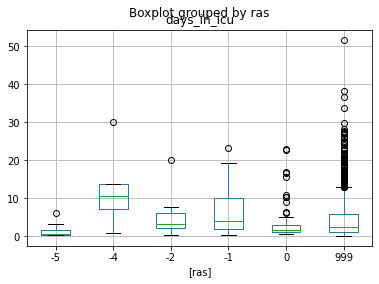

In [143]:
copy.boxplot(by = "ras")

days_in_icu    AxesSubplot(0.1,0.15;0.8x0.75)
dtype: object

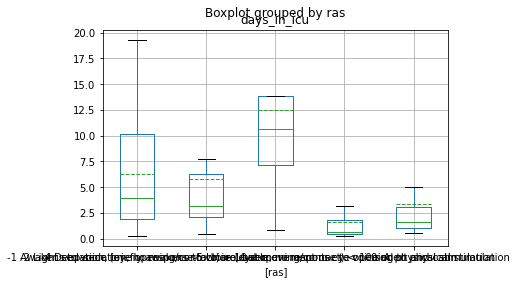

In [102]:
copy.boxplot(by = "ras", meanline=True, showmeans=True, showcaps=True, 
                showbox=True, showfliers=False, return_type='axes')